# Producing the Main figure.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from kinematics_and_rotation.dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the data and make cuts.

In [28]:
gaia_mc0 = pd.read_csv("gaia_mc2.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
# gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
# print(np.shape(gaia_mc1), "no visual binaries or subgiants")
gaia_mc1 = gaia_mc0

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3500, 6000
# mint, maxt = 3500, 5500
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

# Try cutting out stars with latitudes greater than bmax degrees
# bmax = 20
bmax = 15
# bmin = 10
# m &= (gaia_mc1.b.values < bmax) * (bmin < gaia_mc1.b.values)
m &= (gaia_mc1.b.values < bmax)
print(np.shape(gaia_mc1.iloc[m]), "no high latitude stars")

gaia_mc = gaia_mc1.iloc[m]

# # Restrict to stars with Vz
# m &= np.isfinite(gaia_mc1.vz.values)
# print(np.shape(gaia_mc1.iloc[m]), "only stars with Vz")

# Remove velocity outliers
v_clipped, clipping_mask = sigma_clip(gaia_mc.vb.values, 3)
gaia_mc = gaia_mc.iloc[clipping_mask]

(31357, 133)
(29462, 133) no large vb uncertainties
(29243, 133) no faint stars
(24608, 133) no rapid rotators
(20541, 133) no hot or cold stars
(14306, 133) no high latitude stars
niter =  8 239 stars removed kurtosis =  0.07478255034561787


Make cuts in rotation period.

In [29]:
x = gaia_mc.color_teffs.values
y = gaia_mc.Prot.values
v = gaia_mc.vb.values
verr = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100
xlim = (maxt + 100, mint - 200)

tbins = np.linspace(min(x), max(x), 10)

period_bins = 10**np.linspace(np.log10(7), np.log10(50), 9)
mid_period_bins = period_bins[:-1] + .5*np.diff(period_bins)
period_masks = select_stars(gaia_mc, period_bins, "Prot")

pds, pderrs = [np.zeros((len(mid_period_bins), len(tbins[:-1]))) for i in range(2)]

Calculate velocity dispersions.

In [30]:
for i, m in enumerate(period_masks):
    d, derr, k, kerr = MC_dispersion(x[m], v[m], xerr[m], verr[m], tbins, 1000, method="std")
    pds[i, :] = d
    pderrs[i, :] = err_on_sample_std_dev(d, len(x[m]))

100%|██████████| 1000/1000 [00:01<00:00, 720.11it/s]


Set the colour scale.

In [31]:
cmap = plt.cm.get_cmap('viridis_r')
# vmin, vmax = min(mid_period_bins), max(mid_period_bins)
# color_values = (mid_period_bins - vmin)/(vmax - vmin)
# rgba = cmap(color_values)

pvmin, pvmax = np.min(pds[pds > 0]), np.max(pds[np.isfinite(pds)])
pcolor_values = (pds - pvmin)/(pvmax - pvmin)
prgba_plasma = cmap(pcolor_values)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


Load the Spada & Lanzafame models.

In [32]:
sl = pd.read_csv("spada_lanzafame_models.csv")

Calculate gyro models.

In [33]:
from stardate.lhf import gk_rotation_model
from kinematics_and_rotation.photometric_teff import bprp_to_teff

xs_bprp = np.linspace(.8, 2.8, 100)
xs_teff = bprp_to_teff(xs_bprp)
ages = [.5, 1, 1.5, 2, 2.5, 4, 4.57]
prots = np.zeros((len(ages), len(xs_bprp)))
for i, age in enumerate(ages):
    prots[i, :] = 10**gk_rotation_model(np.log10(age*1e9), xs_bprp)

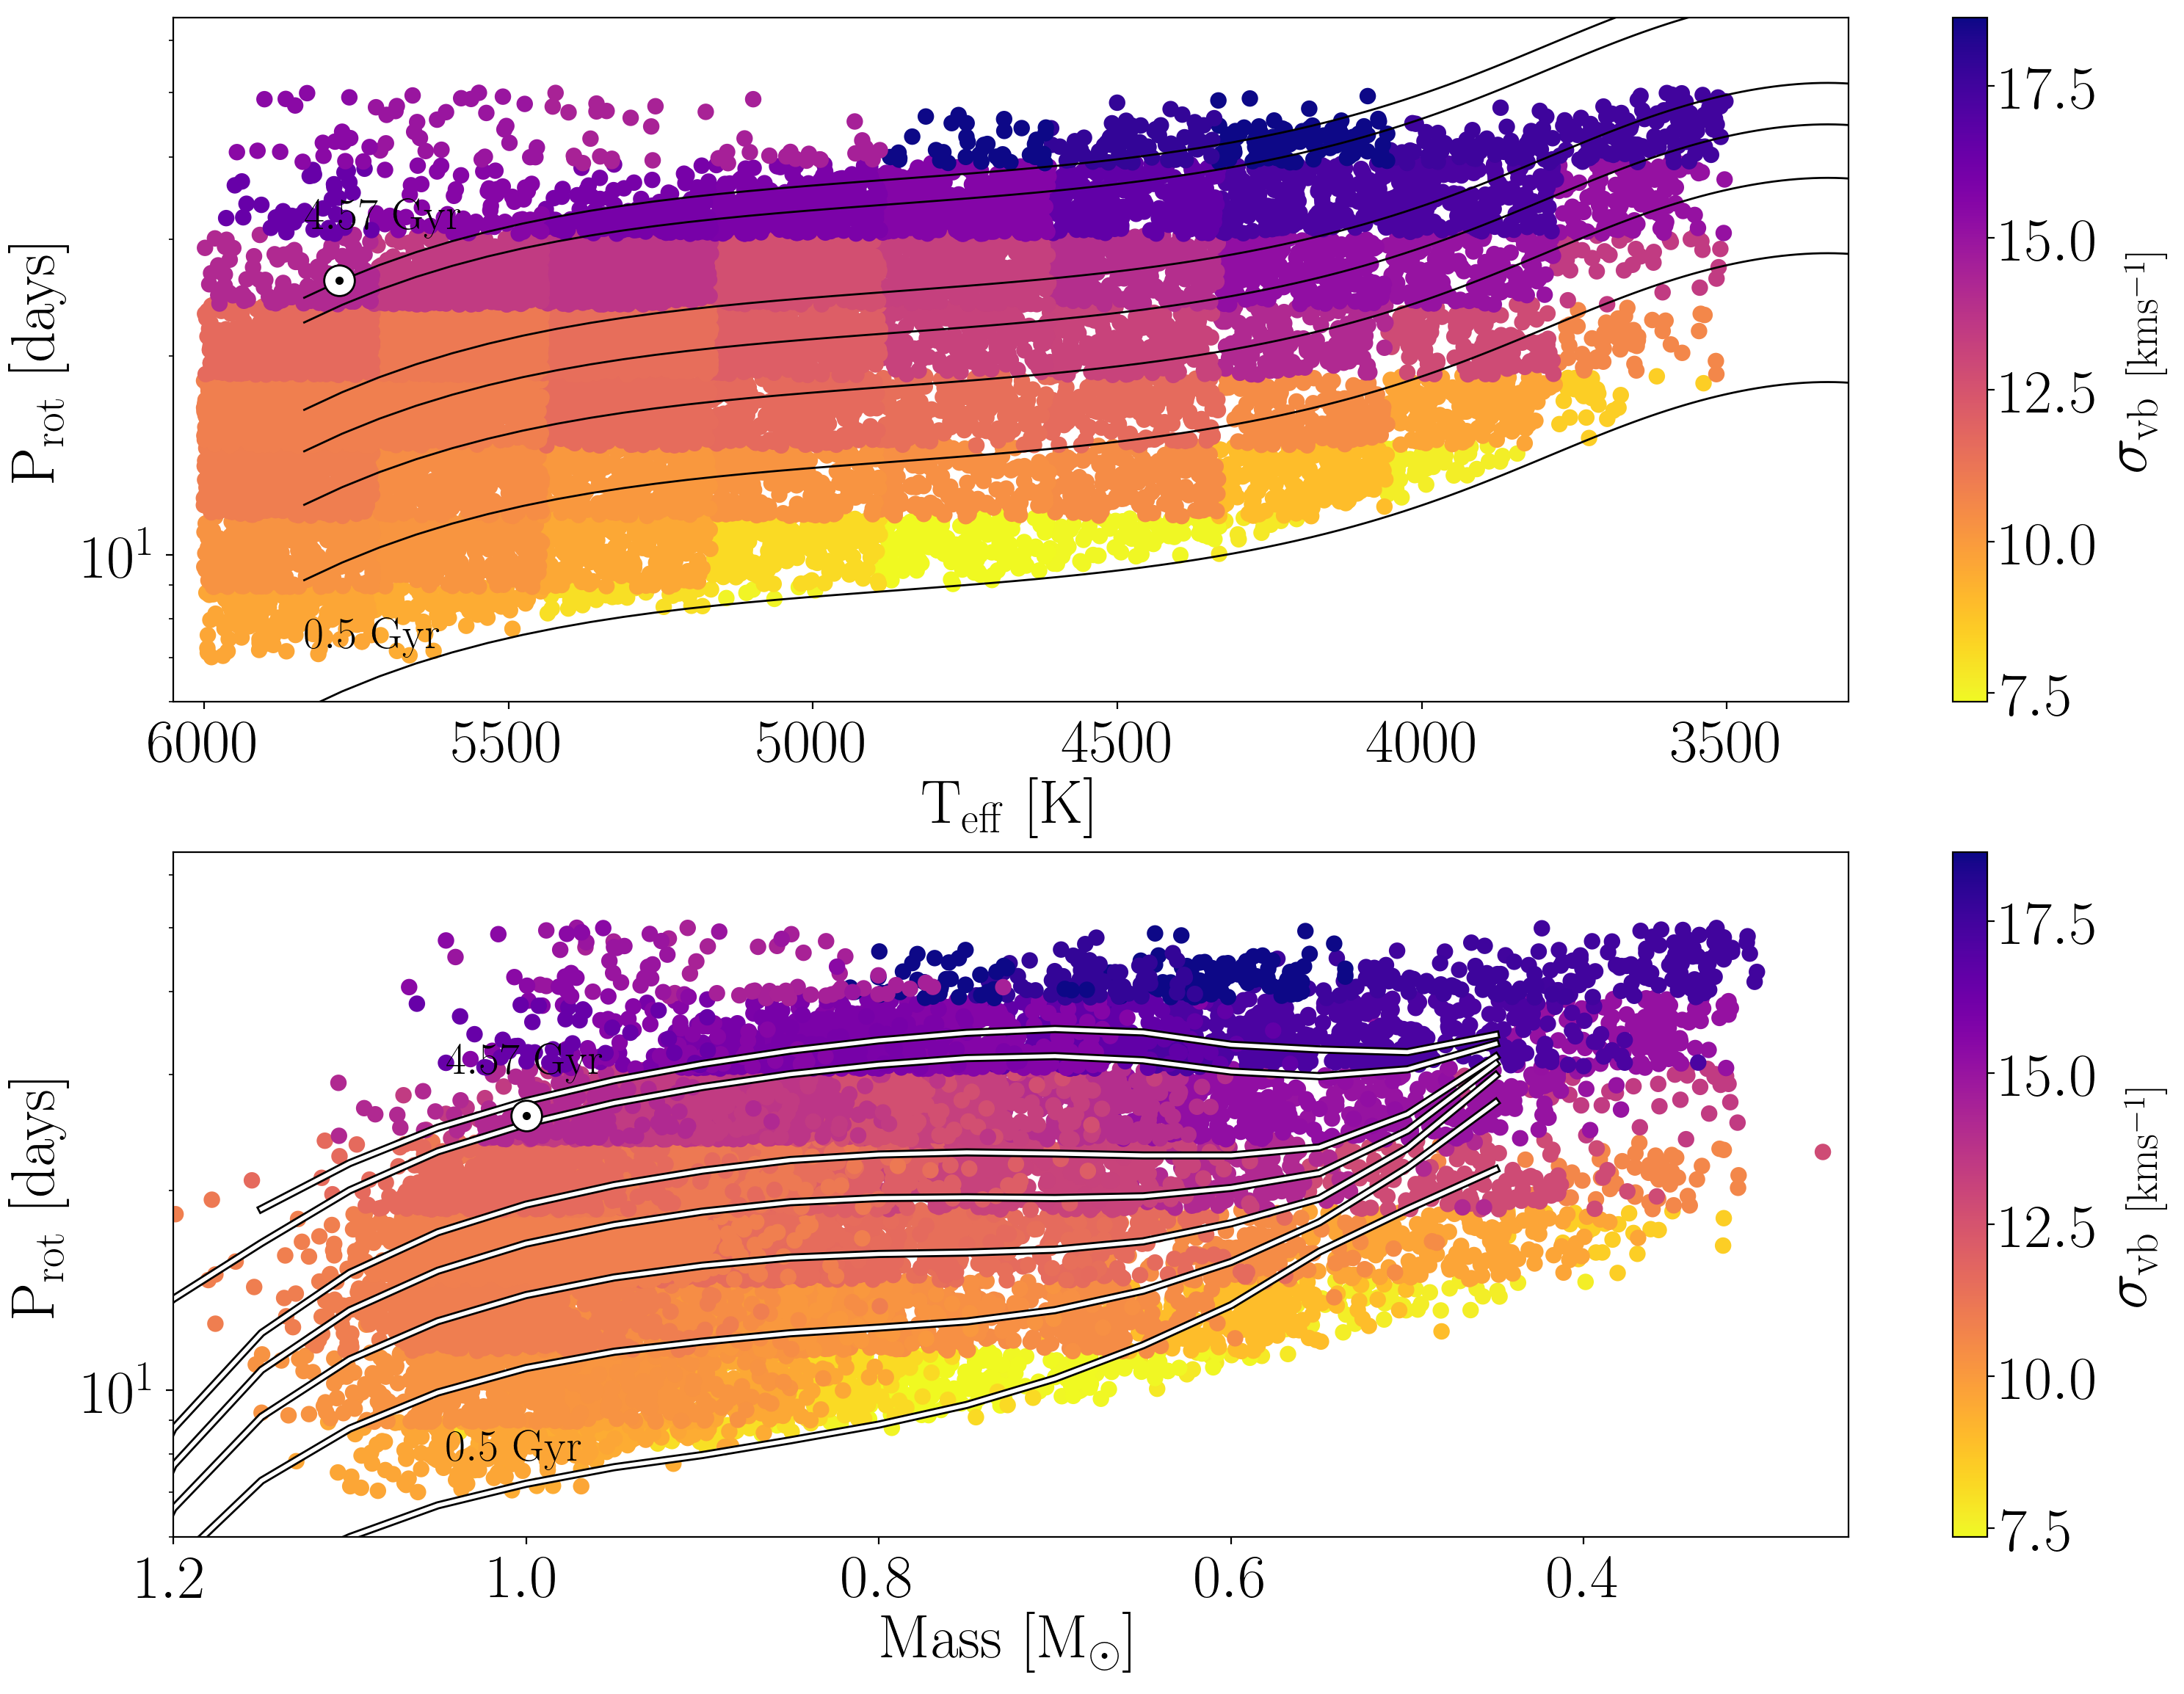

In [35]:
plotpar = {'axes.labelsize': 30,
           'font.size': 22,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)


fig = plt.figure(figsize=(16, 12), dpi=200)
ax1 = fig.add_subplot(211)

for i, m in enumerate(period_masks):
    for j in range(len(tbins)-1):
        tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
        cb1 = plt.scatter(x[m][tm], y[m][tm], c=np.ones_like(y[m][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax, rasterized=True, zorder=1, s=50, cmap="plasma_r")     

lw0, lw1 = 5, 2
# Plot gyro models
for i in range(len(ages)):
#     ax1.plot(xs_teff, prots[i, :], ls="-", lw=lw1, color="k", zorder=2)
    ax1.plot(xs_teff, prots[i, :], ls="-", lw=1, color="k", zorder=1,
             label="$\mathrm{Angus~et~al.~(2019)~model}$")

    
# labels = ["$0.5~\mathrm{Gyr}$", "$2.5~\mathrm{Gyr}$", "$4.57~\mathrm{Gyr}$"]
labels = ["$0.5~\mathrm{Gyr}$", "$4.57~\mathrm{Gyr}$"]
# ys = [7.2, 20, 31]
ys = [7.2, 31]
# xs = [5835, 5835, 5835]
xs = [5835, 5835]
for i in range(len(ys)):
    ax1.text(xs[i], ys[i], labels[i])
    
ax1.plot(5778, 26, "wo", ms=15, mec="k", zorder=4)
ax1.plot(5778, 26, "k.", zorder=5)

# plt.legend(bbox_to_anchor=(0., .92, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)
plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{P_{rot}~[days]}$")
# ax1.set_xlim(5850, min(x)-200)
ax1.set_xlim(6050, 3300)
ax1.set_yscale("log")
# ax1.set_ylim(7, 65)
ax1.set_ylim(6, 65)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")
# ax1.legend()

ax2 = fig.add_subplot(212)
for i, m in enumerate(period_masks):
    for j in range(len(tbins)-1):
        tm = (x[m] > tbins[j]) * (x[m] < tbins[j+1])
        cb1 = plt.scatter(gaia_mc.Mass.values[m][tm], y[m][tm], c=np.ones_like(y[m][tm])*pds[i, j],
                          vmin=pvmin, vmax=pvmax, rasterized=True, zorder=1, s=50, cmap="plasma_r")

plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{P_{rot}~[days]}$")
# ax2.set_xlim(1.05, .25)
ax2.set_xlim(1.2, .25)
ax2.set_yscale("log")
# ax2.set_ylim(7, 65)
ax2.set_ylim(6, 65)
ax2.set_xlabel("$\mathrm{Mass~[M_\odot]}$")

ax2.plot(1, 26, "wo", ms=15, mec="k", zorder=4)
ax2.plot(1, 26, "k.", zorder=5)

# Spada & Lanzafame models
lw0, lw1 = 4, 2
ax2.plot(sl["Mass"], sl["p0.50"], "k", lw=lw0, zorder=1, label="$\mathrm{Spada~\&~Lanzafame~(2019)~model}$")
ax2.plot(sl["Mass"], sl["p1.00"], "k", lw=lw0, zorder=1, label="None")
ax2.plot(sl["Mass"], sl["p1.50"], "k", lw=lw0, zorder=1, label="None")
ax2.plot(sl["Mass"], sl["p2.00"], "k", lw=lw0, zorder=1, label=None)
ax2.plot(sl["Mass"], sl["p2.50"], "k", lw=lw0, zorder=1, label=None)
ax2.plot(sl["Mass"], sl["p4.00"], "k", lw=lw0, zorder=1, label=None)
ax2.plot(sl["Mass"], sl["p4.57"], "k", lw=lw0, zorder=1, label=None)

ax2.plot(sl["Mass"], sl["p0.50"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p1.00"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p1.50"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p2.00"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p2.50"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p4.00"], "w", lw=lw1, zorder=2, label=None)
ax2.plot(sl["Mass"], sl["p4.57"], "w", lw=lw1, zorder=2, label=None)

# ax2.legend()

xs = [1.045, 1.045]
ys = [7.8, 30]
for i in range(len(ys)):
    ax2.text(xs[i], ys[i], labels[i])

plt.tight_layout()
plt.subplots_adjust(hspace=.22)

plt.savefig("main_figure.pdf")
plt.savefig("main_figure")